<a href="https://colab.research.google.com/github/temii70/Lung-Cancer-Detection/blob/main/Copy_of_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, I will implement and compare the performance of seven machine learning algorithms: Support Vector Machine, K-Nearest Neighbours, Random Forest, Extreme Gradient Boosting, Logistic Regression, Light Gradient Boosting Machine, and Categorical Boosting algorithm on a Kaggle lung cancer dataset. The dataset is available via this link:https://www.kaggle.com/datasets/mysarahmadbhat/lung-cancer. It contains patient information and labels that will be used to build the predictive models. You can follow alongside in the Jupyter Notebook as I guide you through each step of the process.

Let's begin by importing all the necessary packages.





In [ ]:
!pip install catboost
!pip install scikit-learn==1.5.2

import pandas as pd
from sklearn import svm  # I recommend using scikit-learn==1.5.2 as there are some compatibility issues with Xgboost
from xgboost import XGBClassifier
#Since this is a classification problem we will be using classification models
from lightgbm import LGBMClassifier as lgbmc
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score, StratifiedKFold
from sklearn.metrics import precision_score,recall_score, f1_score,accuracy_score,confusion_matrix, classification_report, roc_curve,auc, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



To get started, we will need to do some feature preparation. Since our target and gender columns are not in numeric form, we will need to convert them into a format our models can understand.

In [ ]:
dir_path = '/survey lung cancer.csv'  #Replace with your own path to directory where the dataset is
Lung_data_csv_file = pd.read_csv(dir_path)   #Extracting the file into a pandas DataFrame
y_class =  Lung_data_csv_file['LUNG_CANCER'] #Storing the target variable for visualization purposes
Lung_data_csv_file['GENDER'] =  Lung_data_csv_file['GENDER'].apply(lambda x: 2 if x == 'M' else 1) #Encoding the strings to numeric values
Lung_data_csv_file['LUNG_CANCER'] =  Lung_data_csv_file['LUNG_CANCER'].apply(lambda x: 1 if x == 'YES' else 0)






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now we can see what our transformed dataset looks like:

In [ ]:
Lung_data_csv_file


,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,2,69,1,2,2,1,1,2,1,2,2,2,2,2,2,1
1,2,74,2,1,1,1,2,2,2,1,1,1,2,2,2,1
2,1,59,1,1,1,2,1,2,1,2,1,2,2,1,2,0
3,2,63,2,2,2,1,1,1,1,1,2,1,1,2,2,0
4,1,63,1,2,1,1,1,1,1,2,1,2,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,1,56,1,1,1,2,2,2,1,1,2,2,2,2,1,1
305,2,70,2,1,1,1,1,2,2,2,2,2,2,1,2,1
306,2,58,2,1,1,1,1,1,2,2,2,2,1,1,2,1
307,2,67,2,1,2,1,1,2,2,1,2,2,2,1,2,1


One thing to note is that our dataset is highly skewed, with 87% of our patients having lung cancer. We can see this by plotting a pie chart:

,count
LUNG_CANCER,
YES,270
NO,39


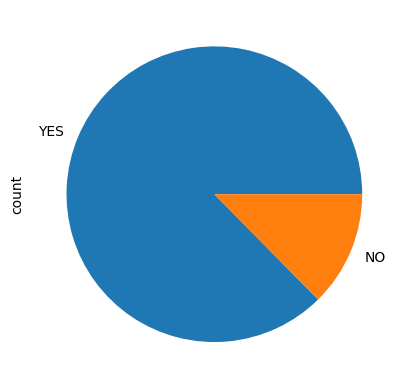

In [ ]:
y_class.value_counts().plot.pie()
y_class.value_counts() #Shows the proportion of lung cancer to no lung cancer

Before we can address this imbalance, we will first need to split our data into training and test data and then normalize it, since some features such as age have a different scale than other features. Normalization ensures that each feature will have a mean of 0 and a standard deviation of 1. This effectively sets all our features to the same scale.

In [ ]:
X =  Lung_data_csv_file.drop(columns=['LUNG_CANCER'])
y = Lung_data_csv_file['LUNG_CANCER']


X_train, X_test, y_trained, y_test = train_test_split(X,y, random_state=10,test_size=0.25)
scaletransformer = StandardScaler() #This will standardize our features
X_trained_pd =  pd.DataFrame(scaletransformer.fit_transform(X_train),columns=X.columns)  #Applying StandardScaler to the training data
X_test_df  = pd.DataFrame(scaletransformer.transform(X_test),columns=X.columns)  #Applying StandardScalar to the test data



We can see what our training dataset looks like now:

In [ ]:
X_trained_pd

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN
0,0.945221,-0.542564,0.873704,-1.124591,-0.995680,-1.030776,-1.039750,0.707107,0.889212,0.820922,0.897044,0.820922,0.734847,-0.897044,0.912871
1,-1.057954,1.556023,-1.144552,0.889212,1.004338,0.970143,0.961769,0.707107,0.889212,0.820922,-1.114773,0.820922,0.734847,1.114773,0.912871
2,0.945221,-0.892328,0.873704,-1.124591,-0.995680,-1.030776,-1.039750,0.707107,0.889212,-1.218142,-1.114773,-1.218142,0.734847,-0.897044,0.912871
3,-1.057954,1.322847,-1.144552,0.889212,1.004338,0.970143,0.961769,0.707107,-1.124591,0.820922,0.897044,-1.218142,-1.360828,-0.897044,-1.095445
4,-1.057954,1.206258,0.873704,-1.124591,-0.995680,0.970143,-1.039750,0.707107,0.889212,0.820922,0.897044,0.820922,-1.360828,1.114773,0.912871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,0.945221,-1.825034,0.873704,0.889212,-0.995680,-1.030776,0.961769,-1.414214,-1.124591,-1.218142,-1.114773,-1.218142,-1.360828,-0.897044,0.912871
227,-1.057954,0.390141,0.873704,0.889212,1.004338,-1.030776,0.961769,0.707107,0.889212,0.820922,0.897044,0.820922,0.734847,-0.897044,-1.095445
228,-1.057954,-1.708445,-1.144552,0.889212,1.004338,0.970143,0.961769,0.707107,0.889212,0.820922,-1.114773,0.820922,0.734847,1.114773,-1.095445
229,-1.057954,-1.125505,-1.144552,0.889212,1.004338,0.970143,0.961769,0.707107,0.889212,-1.218142,-1.114773,0.820922,0.734847,-0.897044,-1.095445


To fix this imbalance, we can use a technique called SMOTE. SMOTE oversamples the minority class using the k-nearest neighbors to synthetically create new artificial data points to balance out the distribution.

Note: we do not apply SMOTE to our test set because the test set is meant to represent real-world data. Often times real-world datasets are imbalanced and applying smote would artificially alter the distribution, leading to unrealistic results.

In [ ]:
smote =  SMOTE(sampling_strategy='minority',random_state=10)
X_trained_df, y_train = smote.fit_resample(X_trained_pd,y_trained)  #applying SMOTE to our training data


We can see the effects of applying SMOTE to our dataset:

,count
LUNG_CANCER,
1,200
0,200


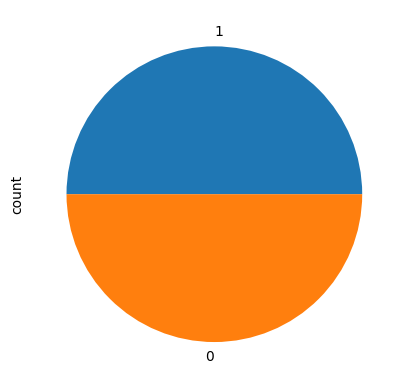

In [ ]:
y_train.value_counts().plot.pie()
y_train.value_counts()

Now that our dataset is balanced, we can begin our trials. We will use cross-validation for each model to find the most optimal hyperparameters. We can evaluate the performance of our model using metrics such as recall, accuracy, precision, f1 score, and a confusion matrix. Our main objective for all our models is to maximize recall, since it is more important we classify the amount of true positives as much as possible. This means we do not want patients with cancer to be falsely diagnosed as having no cancer.

We will start off with the Support Vector Machine(SVM). An SVM is a supervised machine learning algorithm that uses a margin to separate data into different categories. The margin is the distance between the hyperplane and the closet datapoint from each class. The goal of the SVM is to maximize the margin as much as possible while keeping the number of misclassifications low. When the dataset is not linearly separable, the SVM uses a formula called the 'kernel trick' which projects data into a higher dimension.

In [ ]:


Svm_param_grid = {
    'C': [1,2,3],   # C is the regularization parameter. Lower values allow more misclassification (weaker regularization), while higher values reduce misclassification (stronger regularization)
 'kernel': ['linear','poly', 'rbf','sigmoid'], #The kernel is a mathematical formula that maps our data points into higher dimensions to make it easier to find a decision boundary
 'degree' : [2,3],  #Used only by the polynomial kernel and its used to define the degree of the polynomial function that maps data into higher dimensions
 'gamma' : [0.0001,0.01,0.02,0.03,0.04], # Controls the width of the decision boundaries. High gamma means lower influence from each data point, while low gamma indicates stronger influence from each data point
 }



svm_grid_search = GridSearchCV(svm.SVC(probability = True,gamma='auto'),Svm_param_grid, scoring = 'recall',cv=5) # We use gridseach to find the best hyperparameters. We set the scoring to recall because we want to maximize recall (the proportion of true positives) as much as possible
svm_grid_search.fit(X_trained_df,y_train)


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=SVC(gamma='auto', probability=True),
             param_grid={'C': [1, 2, 3], 'degree': [2, 3],
                         'gamma': [0.0001, 0.01, 0.02, 0.03, 0.04],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='recall')

Gridsearch has alot of useful attributes. One such feature is being able to see the best hyperparameters:

In [ ]:
svm_grid_search.best_params_

{'C': 1, 'degree': 3, 'gamma': 0.0001, 'kernel': 'poly'}

We can see the results of our SVM model:

recall: 0.99
accuracy_score: 0.94
precision_score: 0.95
f1_score: 0.97
              precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           1       0.95      0.99      0.97        70

    accuracy                           0.94        78
   macro avg       0.87      0.74      0.79        78
weighted avg       0.93      0.94      0.93        78



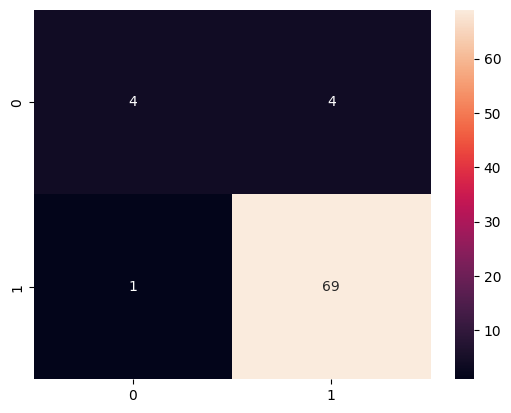

In [ ]:

svm_best_model =  svm_grid_search.best_estimator_ #Storing the best model from gridsearch
svm_predictions = svm_best_model.predict(X_test_df)


svm_recall_best_model =  round(recall_score(y_test,svm_predictions),2)
svm_accuracy_best_model = round(accuracy_score(y_test,svm_predictions),2)
svm_precision_best_model = round(precision_score(y_test,svm_predictions),2)
svm_f1score_best_model = round(f1_score(y_test,svm_predictions),2)



print('recall:', svm_recall_best_model)
print('accuracy_score:', svm_accuracy_best_model)
print('precision_score:',svm_precision_best_model)
print('f1_score:', svm_f1score_best_model)
print(classification_report(y_test,svm_predictions))

svm_best_model_confusion_matrix = confusion_matrix(y_test,svm_predictions)
sns.heatmap(svm_best_model_confusion_matrix,annot=True)  #Plotting our confusion matrix


svm_probabilities = svm_best_model.predict_proba(X_test_df)[:,1]  # We are collecting the probabilities for class 1 ( the positive class) to use for the AUC curve
svm_precision, svm_recall, svm_threshold = precision_recall_curve(y_test,svm_probabilities)  #Storing for later data visualization
svm_auc_curve = auc(svm_recall,svm_precision) #We are calculating the AUC score for the precision-recall curve so we can  plot the precision recall curve at the end of our model testing

svm_tpr, svm_fpr, svm_roc_threshold = roc_curve(y_test,svm_probabilities)  #Storing for later data visualization
svm_roc_curve = auc(svm_fpr,svm_tpr) #Storing for later data visualization


As we can see, our model is highly effective at predicting instances of lung cancer with a recall of 99%. However, it struggles with identifying patients without lung cancer as indicated by a recall of 50%. The f1 score of 97% indicates that our model performs well overall, even though the dataset is imbalanced with more cancer cases.

The K Nearest Neighbors Classifier is a supervised learning algorithm that uses its k nearest neighbours to classify what class the data belongs to, by using majority voting. The distance works by calculating the distance between the data point and other data points in the dataset.

In [ ]:
knn_params_grid = {
'weights': ['uniform','distance'], #Decides how the weight of each neighbor is determined
'n_neighbors':[1,2,3,4], #Number of nearest neighbors to consider in the algorithm
'algorithm': ['ball_tree'], #We will use the ball_tree algorithm, as it is the most efficient algorithm for our dataset
'p':[1,2,3],  #This determines the power parameter for the Minkowski metric
'metric':['minkowski'], #This encapulates both the manhattan_distance and euclidean_distance so it is less computionally expensive
'leaf_size' : [1,2,3], #This determines the leaf size for the ball_tree algorithm

}


knn_model_grid_search = GridSearchCV(KNeighborsClassifier(), knn_params_grid, scoring='recall', cv=5)
knn_model_grid_search.fit(X_trained_df,y_train)




GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree'], 'leaf_size': [1, 2, 3],
                         'metric': ['minkowski'], 'n_neighbors': [1, 2, 3, 4],
                         'p': [1, 2, 3], 'weights': ['uniform', 'distance']},
             scoring='recall')

We can see the best hyperparameters for the Knn model:

In [ ]:
knn_model_grid_search.best_params_


{'algorithm': 'ball_tree',
 'leaf_size': 1,
 'metric': 'minkowski',
 'n_neighbors': 1,
 'p': 1,
 'weights': 'uniform'}

And we can see our results for the Knn model:

recall: 0.91
accuracy_score: 0.9
precision_score: 0.97
f1_score: 0.94
              precision    recall  f1-score   support

           0       0.50      0.75      0.60         8
           1       0.97      0.91      0.94        70

    accuracy                           0.90        78
   macro avg       0.73      0.83      0.77        78
weighted avg       0.92      0.90      0.91        78



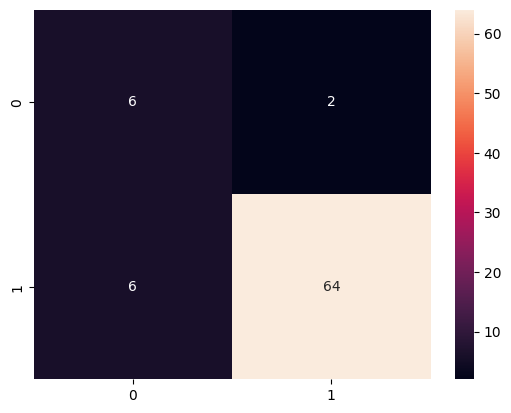

In [ ]:
best_knn_model =  knn_model_grid_search.best_estimator_
knn_predictions = best_knn_model.predict(X_test_df)



recall_knn_best_model =  round(recall_score(y_test,knn_predictions),2)
accuracy_knn_best_model = round(accuracy_score(y_test,knn_predictions),2)
precision_knn_best_model = round(precision_score(y_test,knn_predictions),2)
f1score_knn_best_model = round(f1_score(y_test,knn_predictions),2)


print('recall:', recall_knn_best_model)
print('accuracy_score:', accuracy_knn_best_model)
print('precision_score:', precision_knn_best_model)
print('f1_score:', f1score_knn_best_model)
print(classification_report(y_test,knn_predictions))


best_model_knn_confusion_matrix = confusion_matrix(y_test,knn_predictions)
sns.heatmap(best_model_knn_confusion_matrix,annot=True)


knn_probabilities = best_knn_model.predict_proba(X_test_df)[:,1]
knn_precision, knn_recall, knn_threshold = precision_recall_curve(y_test,knn_probabilities)
knn_auc_curve =  auc(knn_recall, knn_precision)

knn_tpr, knn_fpr, knn_roc_threshold = roc_curve(y_test,knn_probabilities)
knn_roc_curve =  auc(knn_fpr,knn_tpr)


We can see that our model did well for the positive class( cancer), but not as well on recall for the negative class(no cancer). Our model does well overall with a high f1 score of 94% and a high precision score of 97%. This indicates our model is good at identifying cancer cases correctly,  


 A Random Forest Classifier(RF) is a supervised machine learning algorithm that uses an ensemble of decision trees to make classifications. It works by creating multiple decision trees during training and using a technique called 'bagging'.  It selects the class for the data point by majority voting.


In [ ]:

RF_param_grid =  {'n_estimators':[8,9,],  #The number of trees in the forest
                   'criterion':['entropy', 'gini','log_loss'], #The function to measure the quality of a split
                   'min_samples_split':[2,3,10,11],  #Minimum number of samples required to split a internal node
                   'class_weight':['balanced',None], #Determines the weights of each class. If none all the weights are equal
                   'bootstrap':[True], # Whether to sample the dataset with replacement for building each tree
                   'max_features':['log2','sqrt',None], #The number of features to consider when looking for the best split
                   'min_weight_fraction_leaf':[0.0,0.2,0.3],
                   }

RF_grid_search = GridSearchCV(RandomForestClassifier(random_state=10),RF_param_grid, scoring='recall',return_train_score=True, cv=5)

RF_grid_search.fit(X_trained_df,y_train)




GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=10),
             param_grid={'bootstrap': [True],
                         'class_weight': ['balanced', None],
                         'criterion': ['entropy', 'gini', 'log_loss'],
                         'max_features': ['log2', 'sqrt', None],
                         'min_samples_split': [2, 3, 10, 11],
                         'min_weight_fraction_leaf': [0.0, 0.2, 0.3],
                         'n_estimators': [8, 9]},
             return_train_score=True, scoring='recall')

We can see the best hyperparameters for our Random Forest model:

In [ ]:
RF_grid_search.best_params_


{'bootstrap': True,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_features': 'log2',
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 8}

We can see our results for the Random Forest model:

recall: 0.93
accuracy_score: 0.91
precision_score: 0.97
f1_score: 0.95
              precision    recall  f1-score   support

           0       0.55      0.75      0.63         8
           1       0.97      0.93      0.95        70

    accuracy                           0.91        78
   macro avg       0.76      0.84      0.79        78
weighted avg       0.93      0.91      0.92        78



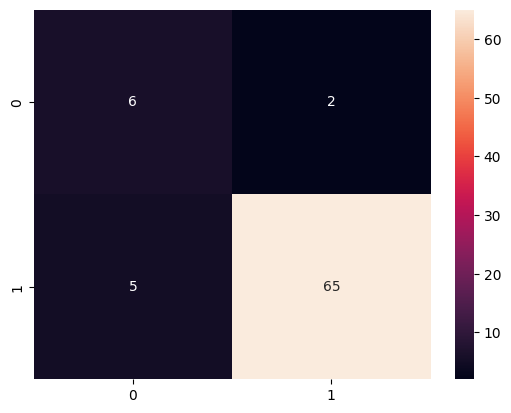

In [ ]:
best_Random_forest_model = RF_grid_search.best_estimator_
RF_predictions = best_Random_forest_model.predict(X_test_df)


recall_RF_model =  round(recall_score(y_test,RF_predictions),2)
accuracy_RF_model = round(accuracy_score(y_test,RF_predictions),2)
precision_RF_model = round(precision_score(y_test,RF_predictions),2)
f1score_RF_model = round(f1_score(y_test,RF_predictions),2)

print('recall:', recall_RF_model)
print('accuracy_score:', accuracy_RF_model)
print('precision_score:', precision_RF_model)
print('f1_score:', f1score_RF_model)
print(classification_report(y_test,RF_predictions))


RF_confusion_matrix = confusion_matrix(y_test,RF_predictions)
sns.heatmap(RF_confusion_matrix,annot=True)



RF_probabilities = best_Random_forest_model.predict_proba(X_test_df)[:,1]
RF_precision, RF_recall, RF_threshold = precision_recall_curve(y_test,RF_probabilities)
RF_auc_curve = auc(RF_recall,RF_precision)

RF_tpr,RF_fpr, RFG_roc_threshold =  roc_curve(y_test,RF_probabilities)
RF_roc_curve =  auc(RF_fpr,RF_tpr)


Our random forest classifier did a pretty good job with a 93% accuracy score for class 1(cancer) but not as well on recall for class 0 (no cancer). Our model is very good at predicting lung cancer as evident by our high f1, and precision scores.


A really cool thing about decision trees and Random Forest is you can see which features were the most important during training:

In [ ]:
features = pd.DataFrame(best_Random_forest_model.feature_importances_, index = X.columns)
features


,0
GENDER,0.047213
AGE,0.084878
SMOKING,0.012510
YELLOW_FINGERS,0.093476
ANXIETY,0.065399
PEER_PRESSURE,0.077041
CHRONIC DISEASE,0.023126
FATIGUE,0.044626
ALLERGY,0.130606
WHEEZING,0.051205


So we see that alcohol consumption, peer pressure, swallowing difficulty, yellow fingers and wheezing are the five most influential features. Future work could focus on further data aggregation and feature selection using these insights.



Xgboost is a supervised machine-learning algorithm that uses an ensemble of weak learners to make classifications. It is a variant of the gradient boosting algorithm but with additional optimizations and hyperparameters such as regularization, and gamma. Xgboost works by sequentially building trees, where each tree improves on the residuals of each tree.

In [ ]:
Xg_boost_param_grid = {
    'n_estimators': [10], #The number of trees in the model
    'max_depth':[6,7], #The maximum number of nodes allowed in each tree
    'max_leaves':[0,2], #The maximum amount of leaves allowed in each tree
    'grow_policy': ['depthwise','lossguide',None], #Controls how new nodes are added to the tree. Depthwise prioritizes balance while loss guide focuses on minimising the loss
    'tree_method' :['hist'], #The tree construction algorithm used in XGBoost
    'learning_rate':[0.3,0.4,0.5], #Step size used in calculating the gradient descent
    'booster': ['gbtree'], #We will use the gbtree algorithm as it is good with non-linear data
    'gamma' : [0.0], #Minimum loss reduction required to make a further split on a leaf node of the tree
    'min_child_weight': [3], #Minimum sum of instance weight needed in a child
    'subsample': [1], #Will randomly sample 100% of the data prior to growing trees
    'sampling_method':['uniform'], #Each training instance has a equal probability of being selected
    'max_delta_step': [0,1,2], #Restricts the model from taking too large of a step size
    'lambda': [1], #Ridge regularization that is added to the leaf scores to prevent overfitting by penalizing large weights
    'scale_pos_weight':[2,3], #Controls the balance of positive and negative weights
    'refresh_leaf':[0,1], #Determines if tree leafs as well as tree node nodes stats are updated
    'max_bin':[256] #Maximum number of discrete bins to bucket continuous features (see documentation)

}
Xg_boost_cv = GridSearchCV(XGBClassifier(random_state = 10), Xg_boost_param_grid,scoring= 'recall', cv=5)
Xg_boost_cv.fit(X_trained_df,y_train)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
             param_grid={'booster': ['gbtree'], 'gamma': [0.0],
                         'grow_policy': ['depthwise', 'lossguide', None],
                         'lambda': [1], 'learning_rate': [0.3, 0.4, 0.5],
                         'max_bin': [256], 'max_delta_step': [0, 1, 2],
                         'max_depth': [6, 7], 'max_leaves': [0, 2],
                         'min_child_weight': [3], 'n_estimators': [10],
                         'refresh_leaf': [0, 1], 'sampling_method': ['uniform'],
                         'scale_pos_weight': [2, 3], 'subsample': [1],
                         'tree_method': ['hist']},
             scoring='recall')

We can see the best parameters for our Xgboost model:

In [ ]:
Xg_boost_cv.best_params_


{'booster': 'gbtree',
 'gamma': 0.0,
 'grow_policy': 'depthwise',
 'lambda': 1,
 'learning_rate': 0.3,
 'max_bin': 256,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 2,
 'min_child_weight': 3,
 'n_estimators': 10,
 'refresh_leaf': 0,
 'sampling_method': 'uniform',
 'scale_pos_weight': 3,
 'subsample': 1,
 'tree_method': 'hist'}

We can see the results for our Xgboost model:

recall: 0.94
accuracy_score: 0.91
precision_score: 0.96
f1_score: 0.95
              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.96      0.94      0.95        70

    accuracy                           0.91        78
   macro avg       0.76      0.78      0.77        78
weighted avg       0.92      0.91      0.91        78



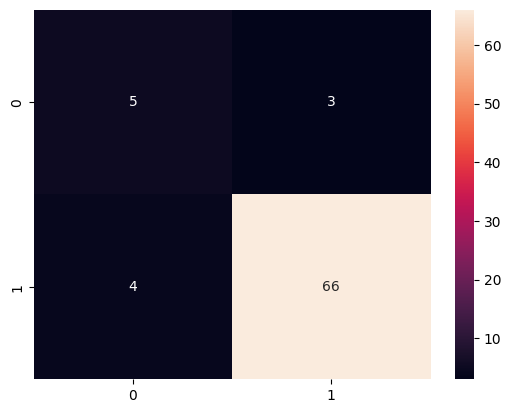

In [ ]:
Xg_boost_best_model = Xg_boost_cv.best_estimator_
Xg_boost_predicitions = Xg_boost_best_model.predict(X_test_df)


recall_Xgboost_model =  round(recall_score(y_test,Xg_boost_predicitions),2)
accuracy_Xgboost_model = round(accuracy_score(y_test,Xg_boost_predicitions),2)
precision_Xgboost_model = round(precision_score(y_test,Xg_boost_predicitions),2)
f1score_Xgboost_model = round(f1_score(y_test,Xg_boost_predicitions),2)

print('recall:', recall_Xgboost_model)
print('accuracy_score:', accuracy_Xgboost_model)
print('precision_score:', precision_Xgboost_model)
print('f1_score:', f1score_Xgboost_model)
print(classification_report(y_test,Xg_boost_predicitions))


RFG_confusion_matrix = confusion_matrix(y_test,Xg_boost_predicitions)
sns.heatmap(RFG_confusion_matrix,annot=True)



Xg_boost_probabilities =  Xg_boost_best_model.predict_proba(X_test_df)[:,1]
Xg_boost_precision, Xg_boost_recall, Xg_boost_threshold = precision_recall_curve(y_test,Xg_boost_probabilities)
Xg_boost_auc_curve = auc(Xg_boost_recall, Xg_boost_precision)

Xg_boost_tpr, Xg_boost_fpr, Xg_boost_threshold = roc_curve(y_test,Xg_boost_probabilities)
Xg_boost_roc_curve = auc(Xg_boost_fpr,Xg_boost_tpr)


Our model does well in predicting lung cancer as shown by the high precision of 96% and a high recall score of 94% for the cancer case as well. However, our model struggles in terms of the minority class(no cancer) with precision and accuracy scores and a f1 score of 59%.   

Logistic Regression is a supervised machine learning algorithm that outputs probabilities between 0 and 1 using the sigmoid function. In the binary classification setting, it comes with a threshold where any prediction above it will be classified as positive and any prediction below it will be classified as negative. In the multiclass environment, it uses an extension called one-vs-all where the model selects the class with the highest probability.

In [ ]:

Logistic_Regression_skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=10)

Logisitc_regression_param_grid = {
'penalty':['l2'], #Using ridge regression (see Xgboost lambda)
'dual' :[False], #Used when n_samples > n_features (see documentation)
'tol' : [0.0,0.0001,0.0003], #Tolerance for stopping criteria
'C' : [1,2,3,4,5], # Inverse of the regularization strength
'fit_intercept': [True,False], #Specifies if a constant/bias/intercept should be added to the decision function
'solver': ['lbfgs'], #The alogrithm used. Since our dataset is small and non linear, we can use lbfgs
'max_iter' : [1000000], #Maximum number of iterations for the solver to converge


}





Logistic_Regression_gridsearch = GridSearchCV(LogisticRegression(random_state=10),Logisitc_regression_param_grid,cv=Logistic_Regression_skf)
Logistic_Regression_gridsearch.fit(X_trained_df,y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10, shuffle=True),
             estimator=LogisticRegression(random_state=10),
             param_grid={'C': [1, 2, 3, 4, 5], 'dual': [False],
                         'fit_intercept': [True, False], 'max_iter': [1000000],
                         'penalty': ['l2'], 'solver': ['lbfgs'],
                         'tol': [0.0, 0.0001, 0.0003]})

We can see the best parameters for the Logistic Regression model:

In [ ]:
Logistic_Regression_gridsearch.best_params_

{'C': 2,
 'dual': False,
 'fit_intercept': True,
 'max_iter': 1000000,
 'penalty': 'l2',
 'solver': 'lbfgs',
 'tol': 0.0003}

And we can see the results for our Logisitic Regression model:

recall: 0.86
accuracy_score: 0.87
precision_score: 1.0
f1_score: 0.92
              precision    recall  f1-score   support

           0       0.44      1.00      0.62         8
           1       1.00      0.86      0.92        70

    accuracy                           0.87        78
   macro avg       0.72      0.93      0.77        78
weighted avg       0.94      0.87      0.89        78



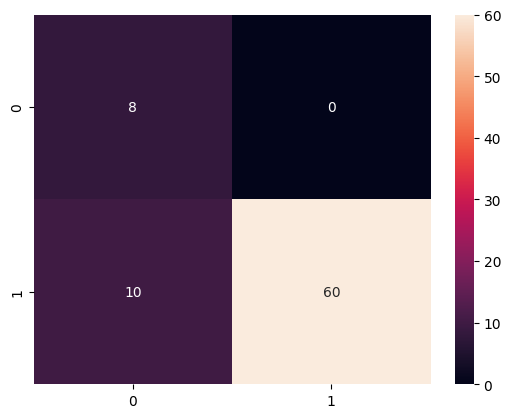

In [ ]:
Logisitic_Regression_Best_Model = Logistic_Regression_gridsearch.best_estimator_
Logisitic_Predicitions =  Logisitic_Regression_Best_Model.predict(X_test_df)

recall_Logistic_Regression =  round(recall_score(y_test,Logisitic_Predicitions),2)
accuracy_Logistic_Regression_model = round(accuracy_score(y_test,Logisitic_Predicitions),2)
precision_Logisitic_Regression_model = round(precision_score(y_test,Logisitic_Predicitions),2)
f1score_Logisitic_Regression_model = round(f1_score(y_test,Logisitic_Predicitions),2)

print('recall:', recall_Logistic_Regression)
print('accuracy_score:', accuracy_Logistic_Regression_model)
print('precision_score:', precision_Logisitic_Regression_model)
print('f1_score:', f1score_Logisitic_Regression_model)
print(classification_report(y_test,Logisitic_Predicitions))

Logisitic_Predictions_confusion_matrix = confusion_matrix(y_test,Logisitic_Predicitions)
sns.heatmap(Logisitic_Predictions_confusion_matrix,annot=True)

Logisitic_probabilities = Logisitic_Regression_Best_Model.predict_proba(X_test_df)[:,1]
Logisitic_precision, Logisitc_recall, Logisitc_threshold = precision_recall_curve(y_test,Logisitic_probabilities)
Logisitic_auc_curve = auc(Logisitc_recall,Logisitic_precision)

Logisitic_tpr,Logisitic_fpr, Logisitic_threshold = roc_curve(y_test, Logisitic_probabilities)
Logisitic_roc_curve = auc(Logisitic_fpr,Logisitic_tpr)

Our Logistic Regression model was able to have a precision of 100% for class 1(cancer)! Our recall and f1 scores might not be as good as our previous models, but these insights could suggest building an ensemble model with Logistic Regression and the SVM or any of the other models to maximize both precision and recall in future works. The precision for class 0 was quite low with  score of 44%, suggesting again that our dataset is very imbalanced with more samples of the positive class than the negative class.

A Light Gradient Boosting Machine (LGBM) classifier is a supervised machine learning algorithm, that is another variant of gradient boosting. LGBM uses mainly decision trees as learners and splits each node leafwise as opposed to gradient-boosting levelwise splits. LGBM also differs from the traditional gradient boosting algorithm by using a gradient-based-one-side sampling(GOSS) technique, where it randomly samples data points with low gradient values with more emphasis on high gradient values.

In [ ]:
Lgbm_params_grid = {
    'boosting_type' :['gbdt'], #Specifies the boosting algorithm to use
    'num_leaves' : [20,25,30], #Maximum tree leaves for base learners
    'max_depth' : [-1,1,3,5], #Maximum tree depth for base learners
    'learning_rate' : [0.3,0.4,0.5,0.6], #See xgboost parameters
    'n_estimators' : [28,30,32], #See xgboost parameters
    'subsample_for_bin' : [1000], #Number of samples for constructing bins
    'objective' : ['binary'],  # We are doing a binary classification
    'subsample':[0.4,0.5,0.6], # Fraction of the training data to randomly sample in each boosting round
    'subsample_freq': [3], #Determines the frequency of the subsample
    'min_split_gain': [0.0,0.00001], #Minimum loss reduction required to make a further partition on a leaf node of the tree
    'min_child_weight' : [0.0,0.0001], #Minimum sum of weights needed in each leaf
    'min_child_samples' : [20,25,30], # Minimum number of data needed in each leaf
    'reg_lambda' :[1], #Decides whether or not to use ridge regularization


}
Lgbm_grid_search =  GridSearchCV(lgbmc(random_state=10),Lgbm_params_grid,scoring='recall',cv=5)
Lgbm_grid_search.fit(X_trained_df,y_train)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 160, number of negative: 160
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 200, number of negative: 200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=10),
             param_grid={'boosting_type': ['gbdt'],
                         'learning_rate': [0.3, 0.4, 0.5, 0.6],
                         'max_depth': [-1, 1, 3, 5],
                         'min_child_samples': [20, 25, 30],
                         'min_child_weight': [0.0, 0.0001],
                         'min_split_gain': [0.0, 1e-05],
                         'n_estimators': [28, 30, 32],
                         'num_leaves': [20, 25, 30], 'objective': ['binary'],
                         'reg_lambda': [1], 'subsample': [0.4, 0.5, 0.6],
                         'subsample_for_bin': [1000], 'subsample_freq': [3]},
             scoring='recall')

And we can see our best parameters:

In [ ]:
Lgbm_grid_search.best_params_

{'boosting_type': 'gbdt',
 'learning_rate': 0.5,
 'max_depth': -1,
 'min_child_samples': 25,
 'min_child_weight': 0.0,
 'min_split_gain': 0.0,
 'n_estimators': 28,
 'num_leaves': 20,
 'objective': 'binary',
 'reg_lambda': 1,
 'subsample': 0.5,
 'subsample_for_bin': 1000,
 'subsample_freq': 3}

We can see our results

recall: 0.91
accuracy_score: 0.91
precision_score: 0.98
f1_score: 0.95
              precision    recall  f1-score   support

           0       0.54      0.88      0.67         8
           1       0.98      0.91      0.95        70

    accuracy                           0.91        78
   macro avg       0.76      0.89      0.81        78
weighted avg       0.94      0.91      0.92        78



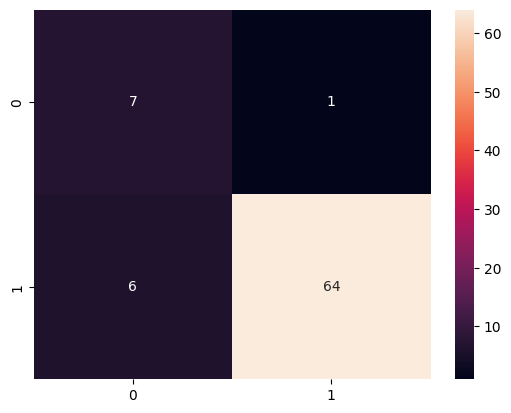

In [ ]:
Lgbm_best_model = Lgbm_grid_search.best_estimator_
Lgbm_predictions = Lgbm_best_model.predict(X_test_df)

recall_Lgbm_model =  round(recall_score(y_test,Lgbm_predictions),2)
accuracy_Lgbm_model = round(accuracy_score(y_test,Lgbm_predictions),2)
precision_Lgbm_model = round(precision_score(y_test,Lgbm_predictions),2)
f1score_Lgbm_model = round(f1_score(y_test,Lgbm_predictions),2)

print('recall:', recall_Lgbm_model)
print('accuracy_score:', accuracy_Lgbm_model)
print('precision_score:', precision_Lgbm_model)
print('f1_score:', f1score_Lgbm_model)
print(classification_report(y_test,Lgbm_predictions))


Lgbm_confusion_matrix = confusion_matrix(y_test,Lgbm_predictions)
sns.heatmap(Lgbm_confusion_matrix,annot=True)



Lgbm_probabilities = Lgbm_best_model.predict_proba(X_test_df)[:,1]
Lgbm_precision, Lgbm_recall, Lgbm_threshold = precision_recall_curve(y_test,Lgbm_probabilities)
Lgbm_auc_curve = auc(Lgbm_recall,Lgbm_precision)

Lgbm_tpr,Lgbm_fpr, Lgbm_predictions = roc_curve(y_test,Lgbm_probabilities)
Lgbm_roc_curve = auc(Lgbm_fpr,Lgbm_tpr)

Our model did pretty well overall with high recall, f1 and precision scores. Similar to logistic Regression, our model did better on precision for class 1 and it has the highest recall for class 0 than any of our previous models.


The Categorical Boosting (Catboost)Classifier is a supervised machine learning algorithm, which is another variant of the gradient-boosting algorithm.  The Catboost algorithm is optimized for categorical data as it uses decision trees as base learners to create different permutations of the dataset and then uses a technique called ordered target encoding. The algorithm also automatically creates new features by combining existing categorical features. These features are designed to capture interactions between categorical features, similar to interaction variables in multiple linear regression.

In [ ]:
Cat_boost_param_grid = {
    'iterations': [150], #The maximum number of trees that can be built
    'learning_rate' : [0.3], #See xgboost parameters
    'l2_leaf_reg' : [0], #Decides whether or not to use ridge regularization
    'bagging_temperature' : [0.0], #Assigns random weights to datapoints(see documentation)
    'eval_metric': ['Logloss'], #Determines which performance metric should be used to evaluate the model's performance
    'colsample_bylevel': [0.1], #The percentage of features to use at each split selection
    'subsample': [0.2], #See Lgbm parameters
    'boosting_type' : ['Ordered'], #Determines the boosting scheme used during model training
    'random_strength' : [0.5], #Controls the level of randomness in the model
    'grow_policy' : ['SymmetricTree'], #Catboost uses symmetric trees to create splits


}


Cat_boost_grid_search = GridSearchCV(CatBoostClassifier(random_state=10),Cat_boost_param_grid,scoring='recall',cv=5)
Cat_boost_grid_search.fit(X_trained_df,y_train)


0:	learn: 0.6843481	total: 325us	remaining: 48.6ms
1:	learn: 0.6080911	total: 1.33ms	remaining: 98.4ms
2:	learn: 0.4663211	total: 2.34ms	remaining: 115ms
3:	learn: 0.4081260	total: 2.93ms	remaining: 107ms
4:	learn: 0.3330380	total: 3.8ms	remaining: 110ms
5:	learn: 0.3330375	total: 4.32ms	remaining: 104ms
6:	learn: 0.2825028	total: 5.34ms	remaining: 109ms
7:	learn: 0.2483677	total: 6.05ms	remaining: 107ms
8:	learn: 0.2426095	total: 6.54ms	remaining: 102ms
9:	learn: 0.2426092	total: 6.99ms	remaining: 97.9ms
10:	learn: 0.2278693	total: 7.64ms	remaining: 96.6ms
11:	learn: 0.2179515	total: 8.17ms	remaining: 94ms
12:	learn: 0.2055719	total: 9.59ms	remaining: 101ms
13:	learn: 0.1897463	total: 10.4ms	remaining: 101ms
14:	learn: 0.1633657	total: 11.8ms	remaining: 106ms
15:	learn: 0.1460772	total: 12.9ms	remaining: 108ms
16:	learn: 0.1444831	total: 13.5ms	remaining: 106ms
17:	learn: 0.1414020	total: 14ms	remaining: 103ms
18:	learn: 0.1301056	total: 15.2ms	remaining: 105ms
19:	learn: 0.1278838	to

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f4d57c80280>,
             param_grid={'bagging_temperature': [0.0],
                         'boosting_type': ['Ordered'],
                         'colsample_bylevel': [0.1], 'eval_metric': ['Logloss'],
                         'grow_policy': ['SymmetricTree'], 'iterations': [150],
                         'l2_leaf_reg': [0], 'learning_rate': [0.3],
                         'random_strength': [0.5], 'subsample': [0.2]},
             scoring='recall')

We can see our best parameters for the Catboost model:

In [ ]:
Cat_boost_grid_search.best_params_

{'bagging_temperature': 0.0,
 'boosting_type': 'Ordered',
 'colsample_bylevel': 0.1,
 'eval_metric': 'Logloss',
 'grow_policy': 'SymmetricTree',
 'iterations': 150,
 'l2_leaf_reg': 0,
 'learning_rate': 0.3,
 'random_strength': 0.5,
 'subsample': 0.2}

And we can see our results for the Catboost model:

recall: 0.94
accuracy_score: 0.94
precision_score: 0.99
f1_score: 0.96
              precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.99      0.94      0.96        70

    accuracy                           0.94        78
   macro avg       0.81      0.91      0.85        78
weighted avg       0.95      0.94      0.94        78



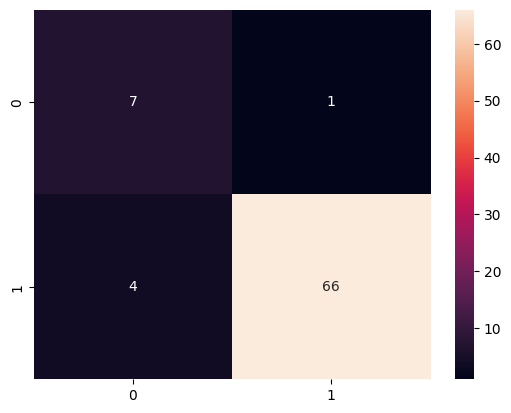

In [ ]:
Cat_boost_best_model = Cat_boost_grid_search.best_estimator_
Cat_boost_predictions =Cat_boost_best_model.predict(X_test_df)

recall_Cat_boost_model =  round(recall_score(y_test,Cat_boost_predictions),2)
accuracy_Cat_boost_model = round(accuracy_score(y_test,Cat_boost_predictions),2)
precision_Cat_boost_model = round(precision_score(y_test,Cat_boost_predictions),2)
f1score_Catboost_model = round(f1_score(y_test,Cat_boost_predictions),2)

print('recall:', recall_Cat_boost_model)
print('accuracy_score:', accuracy_Cat_boost_model)
print('precision_score:', precision_Cat_boost_model)
print('f1_score:', f1score_Catboost_model)
print(classification_report(y_test,Cat_boost_predictions))


Cat_boost_confusion_matrix = confusion_matrix(y_test,Cat_boost_predictions)
sns.heatmap(Cat_boost_confusion_matrix,annot=True)


Cat_boost_probabilities =  Cat_boost_best_model.predict_proba(X_test_df)[:,1]
Cat_boost_precision, Cat_boost_recall, Cat_boost_threshold = precision_recall_curve(y_test,Cat_boost_probabilities)
Cat_boost_auc_curve = auc(Cat_boost_recall, Cat_boost_precision)

Cat_boost_tpr,Cat_boost_fpr,Cat_boost_threshold =  roc_curve(y_test,Cat_boost_probabilities)
Cat_boost_roc_curve = auc(Cat_boost_fpr,Cat_boost_tpr)



Our Catboost model does a good job of predicting cancer cases with a precision score of 99% and a recall score of 94%. The catboost model is also the most well-rounded for both classes boasting a recall score of 88% for class 0 (no cancer) and an f1 score of 74% for class 0. Our Catboost model also has the highest precision score for class 0 out of all our models, suggesting it does better at minimizing the number of false positives.

Now, let's compare the performance of our models to determine which one performs the best overall:



In [ ]:
Model_Comparisons_dic = {
    'Accuracy' : [svm_accuracy_best_model,accuracy_knn_best_model,accuracy_RF_model,accuracy_Xgboost_model,accuracy_Logistic_Regression_model,accuracy_Cat_boost_model],
    'Precision' : [svm_precision_best_model,precision_knn_best_model,precision_RF_model,precision_Xgboost_model,precision_Logisitic_Regression_model,precision_Cat_boost_model],
    'Recall' : [svm_recall_best_model, recall_knn_best_model,recall_RF_model,recall_Xgboost_model,recall_Logistic_Regression,recall_Cat_boost_model],
    'f1_score' : [svm_f1score_best_model,f1score_knn_best_model,f1score_RF_model,f1score_Xgboost_model,f1score_Logisitic_Regression_model,f1score_Catboost_model]
}
Model_compar_pd = pd.DataFrame(Model_Comparisons_dic, index=['SVM','KNN','Random_Forest','Xg_boost','Logisitic_Regression','Cat_boost'])
Model_compar_pd






,Accuracy,Precision,Recall,f1_score
SVM,0.94,0.95,0.99,0.97
KNN,0.90,0.97,0.91,0.94
Random_Forest,0.91,0.97,0.93,0.95
Xg_boost,0.91,0.96,0.94,0.95
Logisitic_Regression,0.87,1.00,0.86,0.92
Cat_boost,0.94,0.99,0.94,0.96


Since recall is our top priority in this setting, the SVM model ranks the highest with a recall of 99%. It performs extremely well in terms of precision (95%), accuracy (94%), and f1 score (97%). These results indicate that the SVM model is particularly effective at identifying true positives (patients with lung cancer) without missing many, which is crucial in medical diagnostics.



We will plot both the precision recall graph and the AUROC curve.The precision recall curve shows how accurate our models are at prediciting lung cancer on the y axis(precision) and how well our model identified non lung cancer cases on the x axis(recall).

The AUROC curve has the false positive rate on the x axis, which is percentage of patients who were falsely diagonsed with lung cancer. The curve has the true posititve rate on the y axis which is the number of patients who had lung cancer and were correctly predicted to have lung cancer.

This will be useful in evaluating how our models did in addition to the other metrics such as the classification report.

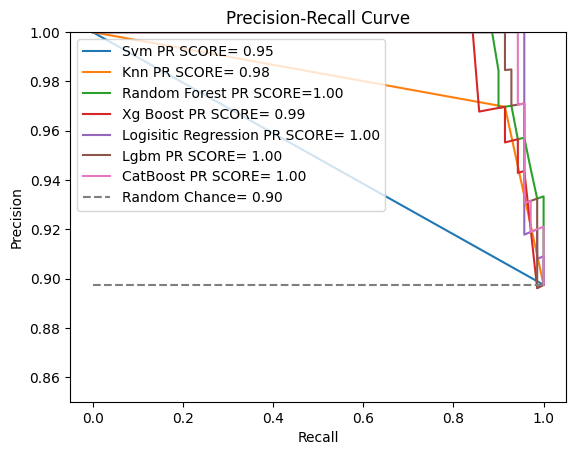

In [ ]:
random_precision = sum(y_test==1)/len(y_test) #Determines the likehood of randomly guessing class 1(cancer)

#Plotting the PR curve
plt.ylim(0.85,1) #Sets the bounds for our y axis so we can see the differences better
plt.plot(svm_recall,svm_precision,label=f'Svm PR SCORE= {svm_auc_curve:.2f}')
plt.plot(knn_recall,knn_precision, label = f'Knn PR SCORE= {knn_auc_curve:.2f}')
plt.plot(RF_recall,RF_precision, label = f'Random Forest PR SCORE={RF_auc_curve:.2f}')
plt.plot(Xg_boost_recall, Xg_boost_precision, label=f'Xg Boost PR SCORE= {Xg_boost_auc_curve:.2f}')
plt.plot(Logisitc_recall, Logisitic_precision, label=f'Logisitic Regression PR SCORE= {Logisitic_auc_curve:.2f}')
plt.plot(Lgbm_recall, Lgbm_precision, label=f'Lgbm PR SCORE= {Lgbm_auc_curve:.2f}')
plt.plot(Cat_boost_recall, Cat_boost_precision, label=f'CatBoost PR SCORE= {Cat_boost_auc_curve:.2f}')
plt.plot([0,1] ,[random_precision,random_precision],linestyle='--',label=f"Random Chance= {random_precision:.2f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()



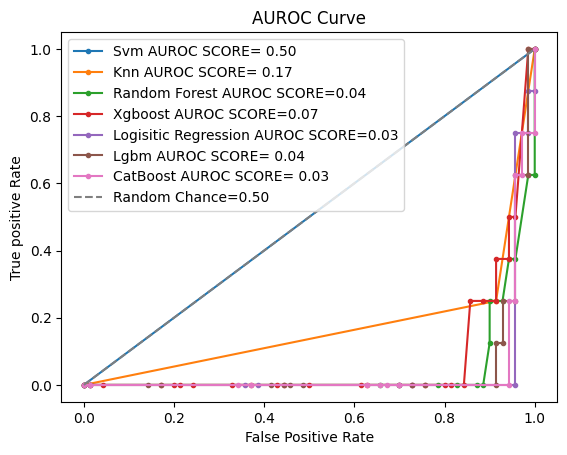

In [ ]:
#Plotting the AUROC curve
plt.plot(svm_fpr,svm_tpr,marker='.', label=f'Svm AUROC SCORE= {svm_roc_curve:.2f}')
plt.plot(knn_fpr,knn_tpr, marker= '.',label = f'Knn AUROC SCORE= {knn_roc_curve:.2f}')
plt.plot(RF_fpr,RF_tpr,marker='.', label = f'Random Forest AUROC SCORE={RF_roc_curve:.2f}')
plt.plot(Xg_boost_fpr,Xg_boost_tpr,marker='.', label = f'Xgboost AUROC SCORE={Xg_boost_roc_curve:.2f}')
plt.plot(Logisitic_fpr,Logisitic_tpr,marker='.', label = f'Logisitic Regression AUROC SCORE={Logisitic_roc_curve:.2f}')
plt.plot(Lgbm_fpr, Lgbm_tpr,marker='.', label=f'Lgbm AUROC SCORE= {Lgbm_roc_curve:.2f}')
plt.plot(Cat_boost_fpr, Cat_boost_tpr, marker = '.',label=f'CatBoost AUROC SCORE= {Cat_boost_roc_curve:.2f}')
plt.plot([0,1],[0,1], linestyle='--' ,label=f'Random Chance=0.50')
plt.xlabel('False Positive Rate')
plt.ylabel('True positive Rate')
plt.title('AUROC Curve')
plt.legend()
plt.show()

The Precision-Recall curve indicates that most of our models perform exceptionally well, with PR scores ranging from 98% to 100%. This aligns with the high precision and recall metrics, as these models are good at identifying class 1 (cancer cases).  A random chance baseline is included for context, emphasizing the imbalance of the dataset as it is at 90%. This means if a model were to guess class 1 randomly, it would have a 90% chance of being correct and would already achieve a high recall.

The AUROC curve tells a different story. Here, the models struggle to balance the true positive and false positive rates, with scores ranging from 0.03 to 0.50. Even the best-performing SVM model achieves an AUROC score of only 0.50, equivalent to random guessing. This indicates that most models face challenges in distinguishing class 0 (no cancer), likely due to the severe class imbalance. While techniques like SMOTE were applied to address this, further work is needed to explore alternative imbalance-handling strategies or feature engineering approaches.





The primary objective of this project was to experiment with different models on a real-world problem and evaluate their performance and accuracy. A key challenge encountered was handling dataset imbalance, which is a common issue in real-world scenarios and requires algorithms capable of addressing such cases. While this project used a single method to tackle the imbalance, numerous alternative approaches could be explored in future work. Further efforts could focus on implementing and comparing different strategies to maximize recall for the positive class while maintaining optimal performance metrics for the negative class.

References:

G. Zixuan, "Research of Forecasting Method of Lung Cancer Based on Machine Learning and Support Vector Machines," 2023 IEEE International Conference on Electrical, Automation and Computer Engineering (ICEACE), Changchun, China, 2023, pp. 517-522, doi: 10.1109/ICEACE60673.2023.10442213.
URL: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10442213&isnumber=10441797

S. Agarwal, S. Thakur and A. Chaudhary, "Prediction of Lung Cancer Using Machine Learning Techniques and their Comparative Analysis," 2022 10th International Conference on Reliability, Infocom Technologies and Optimization (Trends and Future Directions) (ICRITO), Noida, India, 2022, pp. 1-5, doi: 10.1109/ICRITO56286.2022.9965052.
URL: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9965052&isnumber=9964406

Puneet and A. Chauhan, "Detection of Lung Cancer using Machine Learning Techniques Based on Routine Blood Indices," 2020 IEEE International Conference for Innovation in Technology (INOCON), Bangluru, India, 2020, pp. 1-6, doi: 10.1109/INOCON50539.2020.9298407.
URL: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9298407&isnumber=9298025

K. Ingle, U. Chaskar and S. Rathod, "Lung Cancer Types Prediction Using Machine Learning Approach," 2021 IEEE International Conference on Electronics, Computing and Communication Technologies (CONECCT), Bangalore, India, 2021, pp. 01-06, doi: 10.1109/CONECCT52877.2021.9622568.
URL: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9622568&isnumber=9622346


